# Beacon, Fitbit, and EMA Analysis
We look at the BIG three and see what things we can see when considering multiple modalities.

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Initial Exploration
The start to a more complex analysis, here we just look through the data we have for the combined modalities.

In [2]:
import os
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize
from src.reports import make_report

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

import itertools

## Data Import

### Evening IAQ Data
We start by importing the IAQ data from the beacon that has been restricted fully by Fitbit and EMAs

In [3]:
iaq_evening_restricted = pd.read_csv('../data/processed/bpeace2-fitbit-beacon-iaq-evening-restricted.csv',
                                    index_col=0,parse_dates=['Timestamp','start_time','end_time'],infer_datetime_format=True)
iaq_evening_restricted.head()

,TVOC,eCO2,Lux,Visible,Infrared,NO2,T_NO2,RH_NO2,CO,T_CO,...,PM_C_4,PM_C_10,z,Beacon,Beiwe,Fitbit,REDCap,start_time,end_time,beiwe
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-07-04 07:10:00,128.04,400.0,6.2832,196613.0,3.0,NaN,27.0,52.0,-0.91648,NaN,...,16.368654,16.581035,0.154553,44,4i7679py,38,37,2020-07-04 07:07:00,2020-07-04 16:10:00,4i7679py
2020-07-04 07:15:00,124.52,400.0,5.8752,196612.8,3.0,NaN,27.0,52.0,-0.81324,NaN,...,17.515252,17.739183,0.159092,44,4i7679py,38,37,2020-07-04 07:07:00,2020-07-04 16:10:00,4i7679py
2020-07-04 07:20:00,97.08,400.0,4.2432,196612.0,3.0,NaN,27.0,51.0,-0.71760,NaN,...,17.275952,17.501635,0.298510,44,4i7679py,38,37,2020-07-04 07:07:00,2020-07-04 16:10:00,4i7679py
2020-07-04 07:25:00,102.24,400.0,4.2432,196612.0,3.0,NaN,27.0,51.0,-0.73624,NaN,...,15.176323,15.371221,0.287511,44,4i7679py,38,37,2020-07-04 07:07:00,2020-07-04 16:10:00,4i7679py
2020-07-04 07:30:00,106.84,400.0,4.6512,196612.2,3.0,NaN,27.0,51.0,-0.74156,NaN,...,19.510833,19.767971,0.263813,44,4i7679py,38,37,2020-07-04 07:07:00,2020-07-04 16:10:00,4i7679py


### Morning EMAs
We also want the actual EMA data from the sleep surveys

In [4]:
ema = pd.read_csv('../data/processed/bpeace2-morning-survey.csv',
                  index_col=0,parse_dates=True,infer_datetime_format=True)
ema.head()

,ID,Content,Stress,Lonely,Sad,Energy,TST,SOL,NAW,Restful
2020-07-31 09:25:41,hfttkth7,1.0,2.0,1.0,3.0,0.0,6.0,10.0,3.0,0.0
2020-08-19 22:49:04,hfttkth7,1.0,1.0,0.0,1.0,2.0,7.0,20.0,1.0,1.0
2020-08-23 10:58:26,hfttkth7,1.0,1.0,1.0,2.0,0.0,6.0,25.0,0.0,0.0
2020-07-17 09:52:16,hfttkth7,1.0,1.0,0.0,1.0,2.0,7.0,20.0,3.0,2.0
2020-08-12 12:32:54,hfttkth7,1.0,3.0,1.0,2.0,2.0,6.0,20.0,0.0,1.0


### Fitbit Sleep Stages
We also need the recorded Fitbit data.

In [5]:
fitbit = pd.read_csv('../data/processed/bpeace2-fitbit-sleep-stages.csv',
                     index_col='time',parse_dates=['time','start_date','end_date'],infer_datetime_format=True)
fitbit.head()

,Unnamed: 0,start_date,end_date,stage,time_at_stage,beiwe,value
time,,,,,,,
2020-05-14 00:27:00,0,2020-05-14,2020-05-14,wake,510,hfttkth7,0
2020-05-14 00:35:30,1,2020-05-14,2020-05-14,light,420,hfttkth7,1
2020-05-14 00:42:30,2,2020-05-14,2020-05-14,deep,1590,hfttkth7,2
2020-05-14 01:09:00,3,2020-05-14,2020-05-14,light,1290,hfttkth7,1
2020-05-14 01:30:30,4,2020-05-14,2020-05-14,rem,840,hfttkth7,3


## Visualization

In [6]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

### Nightly Time Series
We want to look at a nice time series that shows some pollutant concentrations, the sleep stages, and when the survey was submitted.

Before that, a cursory analysis shows that we have to consider nights when we have both the beacon and EMA response the next day.

#### Checking Survey and IAQ Overlap

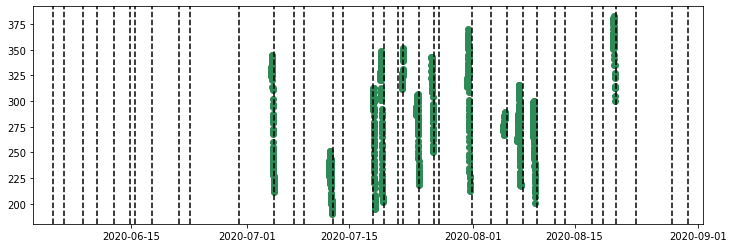

In [7]:
pt = '4i7679py'
iaq_pt = iaq_evening_restricted[iaq_evening_restricted['beiwe'] == pt]
ema_pt = ema[ema['ID'] == pt]
fig,ax = plt.subplots(figsize=(12,4))
ax.scatter(iaq_pt.index,iaq_pt['CO2'],color='seagreen')
for i in range(len(ema_pt)):
    ax.axvline(ema_pt.index[i],color='black',linestyle='dashed')

#### First Attempt

zdpffrox


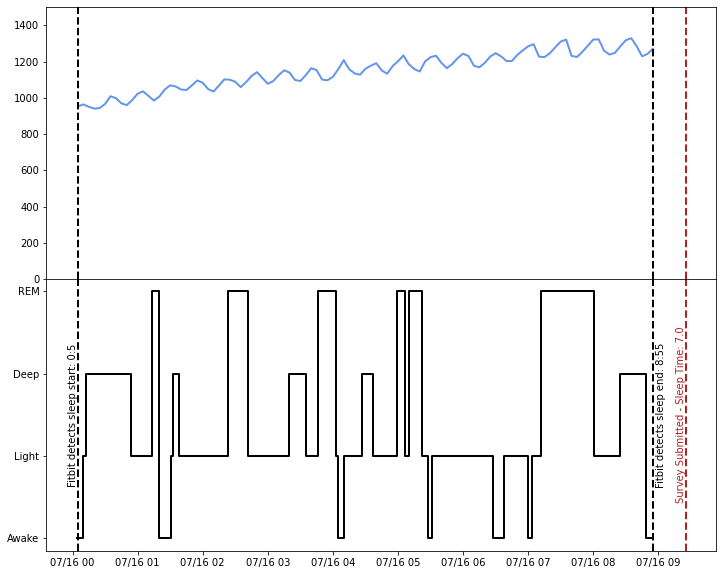

In [8]:
for pt in ['zdpffrox']:#iaq_evening_restricted['beiwe'].unique():
    # restricting to patient
    iaq_pt = iaq_evening_restricted[iaq_evening_restricted['beiwe'] == pt]
    ema_pt = ema[ema['ID'] == pt]
    fb_pt = fitbit[fitbit['beiwe'] == pt]
    print(pt)
    for i in range(len(ema_pt)):
        iaq_pt_night = iaq_pt[iaq_pt['end_time'].dt.date == ema_pt.index[i]]
        fb_pt_night = fb_pt[fb_pt['end_date'].dt.date == ema_pt.index[i]]
        if len(iaq_pt_night['CO2']) > 0 and len(fb_pt_night) > 0:
            # targeting a specific day
            if ema_pt.index[i].date() == datetime(2020,7,16).date():
                fig, axes = plt.subplots(2,1,figsize=(12,10),sharex=True)
                # beacon plot
                ax = axes[0]
                ax.plot(iaq_pt_night.index,iaq_pt_night['CO2'],color='cornflowerblue',linewidth=2)
                ## timeline events
                ax.axvline(ema_pt.index[i],color='firebrick',linewidth=2,linestyle='dashed')
                ax.axvline(iaq_pt_night.index[0],color='black',linewidth=2,linestyle='dashed')
                ax.axvline(iaq_pt_night.index[-1],color='black',linewidth=2,linestyle='dashed')
                ax.set_ylim([0,1500])

                # fitbit plot
                ax = axes[1]
                ## Getting fitbit times
                fb_times = [None]*(len(fb_pt_night.index)+len(fb_pt_night.index)-1)
                fb_times[::2] = fb_pt_night.index
                fb_times[1::2] = fb_pt_night.index[1:]
                fb_times.append(iaq_pt_night['CO2'].index[-1])
                ## Getting fitbit values
                fb_vals = [None]*(len(fb_pt_night['value'])+len(fb_pt_night['value']))
                fb_vals[::2] = fb_pt_night['value']
                fb_vals[1::2] = fb_pt_night['value']
                ## Plotting
                ax.plot(fb_times,fb_vals,color='black',linewidth=2)
                ax.axvline(ema_pt.index[i],color='firebrick',linewidth=2,linestyle='dashed')
                ax.axvline(iaq_pt_night.index[0],color='black',linewidth=2,linestyle='dashed')
                t = f'{iaq_pt_night.index[0].hour}:{iaq_pt_night.index[0].minute}'
                ax.text(iaq_pt_night.index[0],1.5,f'Fitbit detects sleep start: {t}',rotation=90,ha='right',va='center')
                ax.axvline(iaq_pt_night.index[-1],color='black',linewidth=2,linestyle='dashed')
                t = f'{iaq_pt_night.index[-1].hour}:{iaq_pt_night.index[-1].minute}'
                ax.text(iaq_pt_night.index[-1]+timedelta(minutes=3),1.5,f'Fitbit detects sleep end: {t}',rotation=90,ha='left',va='center')
                ema_tst = ema_pt['TST'][i]
                ax.text(ema_pt.index[i],1.5,f'Survey Submitted - Sleep Time: {ema_tst}',rotation=90,color='firebrick',ha='right',va='center')

                ax.set_yticks([0,1,2,3])
                ax.set_yticklabels(['Awake','Light','Deep','REM'])

                ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H'))
                ax.xaxis.set_major_locator(mdates.HourLocator())

                plt.subplots_adjust(hspace=0)
                plt.savefig('../reports/3mt2020/all-modalities-sleep-window.pdf')
                plt.show()
                plt.close()

#### Second Attempt

zdpffrox


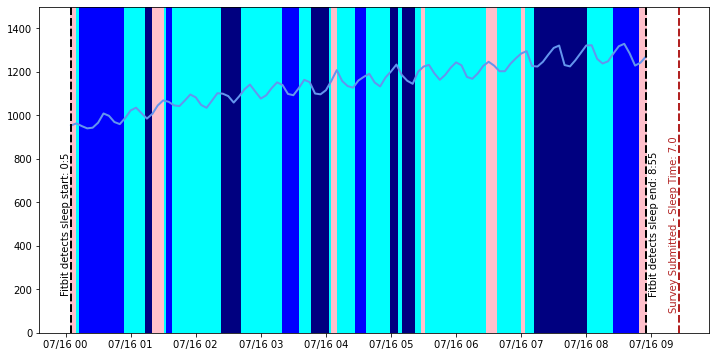

In [9]:
for pt in ['zdpffrox']:#iaq_evening_restricted['beiwe'].unique():
    # restricting to patient
    iaq_pt = iaq_evening_restricted[iaq_evening_restricted['beiwe'] == pt]
    ema_pt = ema[ema['ID'] == pt]
    fb_pt = fitbit[fitbit['beiwe'] == pt]
    print(pt)
    for i in range(len(ema_pt)):
        iaq_pt_night = iaq_pt[iaq_pt['end_time'].dt.date == ema_pt.index[i]]
        fb_pt_night = fb_pt[fb_pt['end_date'].dt.date == ema_pt.index[i]]
        if len(iaq_pt_night['CO2']) > 0 and len(fb_pt_night) > 0:
            # targeting a specific day
            if ema_pt.index[i].date() == datetime(2020,7,16).date():
                fig, ax = plt.subplots(figsize=(12,6),sharex=True)
                # beacon plot
                ax.plot(iaq_pt_night.index,iaq_pt_night['CO2'],color='cornflowerblue',linewidth=2)
                ## timeline events
                ax.axvline(ema_pt.index[i],color='firebrick',linewidth=2,linestyle='dashed')
                ax.axvline(iaq_pt_night.index[0],color='black',linewidth=2,linestyle='dashed')
                ax.axvline(iaq_pt_night.index[-1],color='black',linewidth=2,linestyle='dashed')
                ax.set_ylim([0,1500])

                # fitbit plot
                ## Getting fitbit times
                fb_times = [None]*(len(fb_pt_night.index)+len(fb_pt_night.index)-1)
                fb_times[::2] = fb_pt_night.index
                fb_times[1::2] = fb_pt_night.index[1:]
                fb_times.append(iaq_pt_night['CO2'].index[-1])
                ## Getting fitbit values
                fb_vals = [None]*(len(fb_pt_night['value'])+len(fb_pt_night['value']))
                fb_vals[::2] = fb_pt_night['value']
                fb_vals[1::2] = fb_pt_night['value']
                ## Plotting
                for j in np.arange(0,len(fb_times),2):
                    if fb_vals[j] == 0:
                        color='pink'
                    elif fb_vals[j] == 1:
                        color='cyan'
                    elif fb_vals[j] == 2:
                        color='blue'
                    else:
                        color='navy'
                    ax.axvspan(fb_times[j],fb_times[j+1],color=color)
                ax.axvline(ema_pt.index[i],color='firebrick',linewidth=2,linestyle='dashed')
                ax.axvline(iaq_pt_night.index[0],color='black',linewidth=2,linestyle='dashed')
                t = f'{iaq_pt_night.index[0].hour}:{iaq_pt_night.index[0].minute}'
                ax.text(iaq_pt_night.index[0],500,f'Fitbit detects sleep start: {t}',rotation=90,ha='right',va='center')
                ax.axvline(iaq_pt_night.index[-1],color='black',linewidth=2,linestyle='dashed')
                t = f'{iaq_pt_night.index[-1].hour}:{iaq_pt_night.index[-1].minute}'
                ax.text(iaq_pt_night.index[-1]+timedelta(minutes=3),500,f'Fitbit detects sleep end: {t}',rotation=90,ha='left',va='center')
                ema_tst = ema_pt['TST'][i]
                ax.text(ema_pt.index[i],500,f'Survey Submitted - Sleep Time: {ema_tst}',rotation=90,color='firebrick',ha='right',va='center')

                ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H'))
                ax.xaxis.set_major_locator(mdates.HourLocator())

                plt.subplots_adjust(hspace=0)
                #plt.savefig('../reports/3mt2020/all-modalities-sleep-window.pdf')
                plt.show()
                plt.close()

#### Final Attempt
The figure below is by no means a final product, but usable in illustrator for a final edition.

In [10]:
def create_cmap(colors,nodes):
    cmap = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))
    return cmap

vr9j5rry


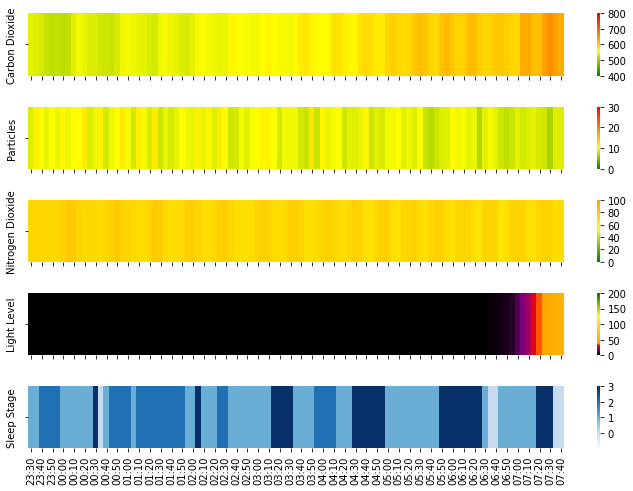

In [11]:
for pt in ['vr9j5rry',]:# iaq_evening_restricted['beiwe'].unique():
    # restricting to patient
    iaq_pt = iaq_evening_restricted[iaq_evening_restricted['beiwe'] == pt]
    ema_pt = ema[ema['ID'] == pt]
    fb_pt = fitbit[fitbit['beiwe'] == pt]
    print(pt)
    for i in range(len(ema_pt)):
        iaq_pt_night = iaq_pt[iaq_pt['end_time'].dt.date == ema_pt.index[i]]
        fb_pt_night = fb_pt[fb_pt['end_date'].dt.date == ema_pt.index[i]]
        if len(iaq_pt_night['CO2']) > 0 and len(fb_pt_night) > 0:
            # target a specific day
            if ema_pt.index[i].date() == datetime(2020,7,13).date():
                ss_wide = pd.DataFrame(data={'time':fb_pt_night.index,'value':fb_pt_night['value']})
                ss_wide.set_index('time',inplace=True)
                ss_wide = ss_wide.resample('5T').ffill()
                iaq_ss = pd.merge(right=iaq_pt_night,left=ss_wide,right_index=True,left_index=True,how='inner')
                iaq_ss = iaq_ss[['CO2','PM_C_2p5','NO2','Lux','value']]

                fig, axes = plt.subplots(5,1,figsize=(12,8),sharex=True)
                ylabels = ['Carbon Dioxide','Particles','Nitrogen Dioxide','Light Level','Sleep Stage']
                cbar_ticks = [np.arange(400,900,100),np.arange(0,40,10),np.arange(0,120,20),np.arange(0,250,50),np.arange(0,4,1)]
                cmaps = [create_cmap(["green", "yellow", "orange", "red",],[0.0, 0.4, 0.6, 1]),
                         create_cmap(["green", "yellow", "red"],[0.0, 0.34, 1]),
                         create_cmap(["green", "yellow", "orange"],[0.0, 0.53, 1]),
                         create_cmap(["black","purple","red","orange","yellow","green"],[0.0, 0.1, 0.16, 0.2, 0.64, 1]),
                         'Blues']
                for ax, var, low, high, ylabel, ticks, cmap in zip(axes,iaq_ss.columns,[400,0,0,0,-1],[800,30,100,200,3],ylabels,cbar_ticks,cmaps):
                    sns.heatmap(iaq_ss[[var]].T,vmin=low,vmax=high,ax=ax,cbar_kws={'ticks':ticks},cmap=cmap)
                    ax.set_ylabel(ylabel)
                    ax.set_yticklabels([''])
                    ax.set_xlabel('')

                xlabels = ax.get_xticklabels()
                new_xlabels = []
                for label in xlabels:
                    new_xlabels.append(label.get_text()[11:16])

                ax.set_xticklabels(new_xlabels)
                plt.subplots_adjust(hspace=0.5)
                plt.savefig('../reports/3mt2020/all-modalities-sleep-window-example.pdf')
                plt.show()
                plt.close()

#### Some Summary Info

In [28]:
print(f'TST: {iaq_ss.index[-1] - iaq_ss.index[0]}')

TST: 0 days 08:10:00


In [27]:
ema_pt['date'] = ema_pt.index.date
ema_pt[ema_pt['date'] == datetime(2020,7,13).date()]

,ID,Content,Stress,Lonely,Sad,Energy,TST,SOL,NAW,Restful,date
2020-07-13 09:37:27,vr9j5rry,2.0,1.0,0.0,0.0,3.0,7.5,25.0,1.0,2.0,2020-07-13


The survey says 7.5 hours and 1 awakening while Fitbit says 8.2 hours and 2 awakenings (don't count the last awakening).